# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy.

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement.

In [4]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('darkgrid')

In [7]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.

    Each step of the log-returns, there is a
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45

    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path

    Returns:

    Simuatled stock paths
    '''

    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))

    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))

    #Time increment between each step
    dt = t/n_steps

    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise

    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)

    #paths
    paths = S0*np.exp(log_returns)

    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)

    return paths, sigma

#Black-Scholes call option pricing#

def bs_call(S0, K, sigma, t, r = 0):
    """
    Computes the Black-Scholes price of a European call option.

    Parameters:
        S0 (float): Current asset price
        K (float): Strike price
        sigma (float): Annualized volatility (standard deviation of log returns)
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate (annualized)

    Returns:
        float: Call option price
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)

    call_price = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    return call_price


#Black-Scholes call option delta#

def bs_call_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)

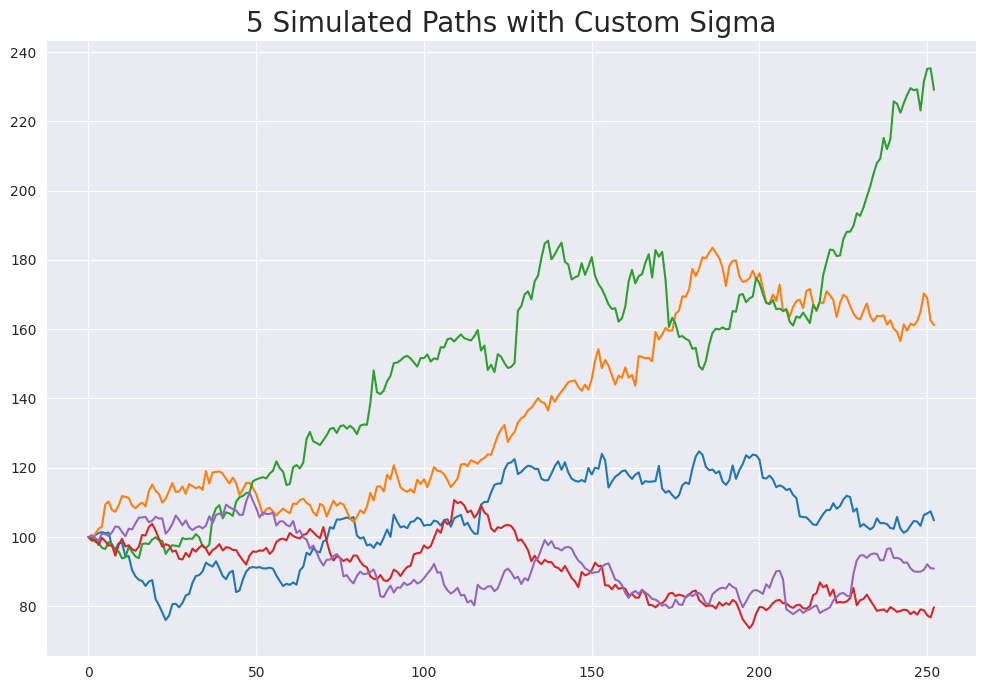

In [17]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths, _ = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)

plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

The sigma_hedging_simulation function


*   List item Buys a call option at a constant implied volatility according to our model (25%)
*   List item Delta hedges until the expiration time of the option
*   List item Calculates the profit and loss from the difference between realized and implied volatility.



Running sigma hedging simulation...
Implied volatility used: 25.0%
Realized volatility regime: 20% (50%), 30% (30%), 45% (20%)
Expected realized volatility: 28.0%
=== SIGMA HEDGING STRATEGY RESULTS ===
Number of simulations: 100
Mean P&L: $44.78
Standard Deviation: $74.94
Maximum P&L: $351.87
Minimum P&L: $-21.12
Probability of Profit: 61.0%

Percentiles:
  5%: $-19.04
  25%: $-17.11
  50%: $18.15
  75%: $92.23
  95%: $165.49


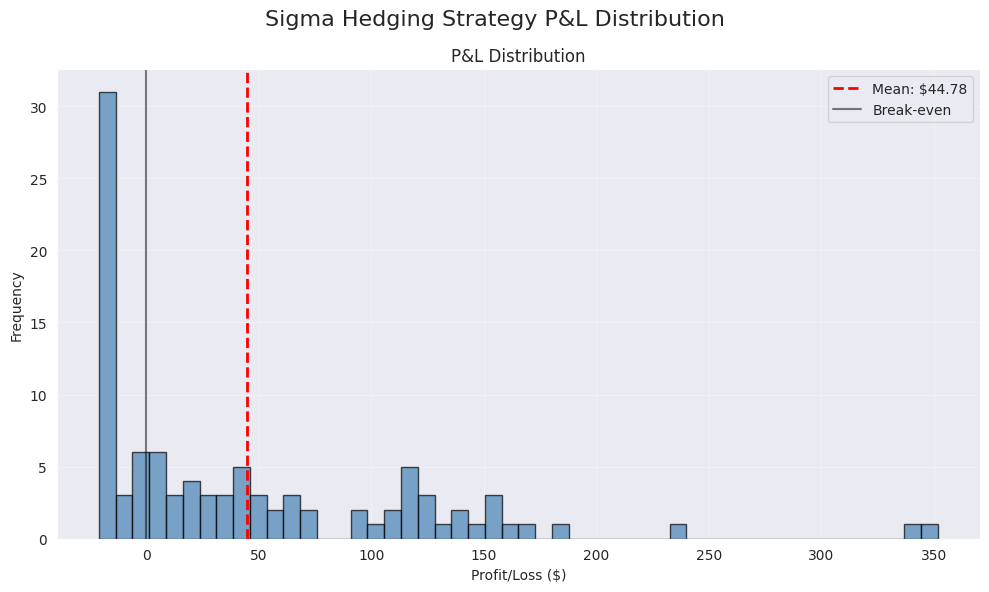


=== VOLATILITY ANALYSIS ===
Implied volatility: 25.0%
Expected realized volatility: 28.0%
Volatility difference: 3.0%
Strategy should be profitable on average (realized > implied)


In [37]:
def sigma_hedging_simulation(S0, K, t, r, mu, implied_vol, n_paths, n_steps):
    '''
    Simulates sigma hedging strategy profit/loss distribution.

    Strategy:
    1. Buy call option at implied volatility
    2. Delta hedge continuously
    3. Profit comes from difference between realized and implied volatility

    Inputs:
    S0 (float): initial stock price
    K (float): strike price of option
    t (float): time to expiration
    r (float): risk-free rate
    mu (float): stock drift
    implied_vol (float): implied volatility used for option pricing
    n_paths (int): number of simulation paths
    n_steps (int): number of hedging steps

    Returns:
    dict: Contains profit/loss for each path and summary statistics
    '''

    # Simulate stock paths with stochastic volatility
    stock_paths, realized_sigmas = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)

    # Time increment
    dt = t/n_steps

    # Initialize arrays to store results
    pnl_paths = np.zeros(n_paths)

    for path in range(n_paths):
        # Get stock path and realized volatilities for this simulation
        S_path = stock_paths[path, :]
        sigma_path = realized_sigmas[path, :]

        # Initialize portfolio components
        option_pnl = 0
        hedge_pnl = 0
        cash_account = 0
        shares_held = 0

        # Initial option purchase
        option_pnl -= bs_call(S0, K, implied_vol, t, r)  # Buy the option

        # Initial delta hedge
        initial_delta = bs_call_delta(S0, K, implied_vol, t, r)
        shares_held = initial_delta
        cash_account -= initial_delta * S0  # Buy shares

        # Hedge at each time increment
        for step in range(n_steps):
            S_current = S_path[step + 1]
            tte = t - (step + 1) * dt

            if tte > 0:
                new_delta = bs_call_delta(S_current, K, implied_vol, tte, r)

                # Rebalance hedge
                delta_change = new_delta - shares_held
                hedge_pnl -= delta_change * S_current
                shares_held = new_delta

            cash_account *= np.exp(r * dt)

        # Final stock price
        final_stock_price = S_path[-1]

        # Option payoff at expiration
        option_pnl +=  max(final_stock_price - K, 0)

        # Hedge profit and loss
        hedge_pnl += shares_held * final_stock_price

        # Total profit and loss
        total_pnl = option_pnl + hedge_pnl + cash_account
        pnl_paths[path] = total_pnl

    # Calculate statistics
    results = {
        'pnl_paths': pnl_paths,
        'mean_pnl': np.mean(pnl_paths),
        'std_pnl': np.std(pnl_paths),
        'max_pnl': np.max(pnl_paths),
        'min_pnl': np.min(pnl_paths),
        'profit_probability': np.mean(pnl_paths > 0),
        'percentiles': {
            '5%': np.percentile(pnl_paths, 5),
            '25%': np.percentile(pnl_paths, 25),
            '50%': np.percentile(pnl_paths, 50),
            '75%': np.percentile(pnl_paths, 75),
            '95%': np.percentile(pnl_paths, 95)
        }
    }

    return results

def plot_sigma_hedging_results(results, title="Sigma Hedging Strategy P&L Distribution"):
    '''Plot the profit/loss distribution'''
    fig, (ax) = plt.subplots(1, 1, figsize=(10, 6))

    # Histogram
    ax.hist(results['pnl_paths'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(results['mean_pnl'], color='red', linestyle='--', linewidth=2, label=f'Mean: ${results["mean_pnl"]:.2f}')
    ax.axvline(0, color='black', linestyle='-', alpha=0.5, label='Break-even')
    ax.set_xlabel('Profit/Loss ($)')
    ax.set_ylabel('Frequency')
    ax.set_title('P&L Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Simulation

S0 = 100          # Initial stock price
K = 110           # Strike price (at-the-money)
t = 1          # 1 year to expiration
r = 0.039          # Risk-free rate
mu = 0.275         # Stock drift
implied_vol = 0.25  # Implied volatility (constant assumption)
n_paths = 100   # Number of simulation paths
#n_steps = 252      # Number of hedging steps
n_steps = 252      # Number of hedging steps

print("Running sigma hedging simulation...")
print(f"Implied volatility used: {implied_vol:.1%}")
print(f"Realized volatility regime: 20% (50%), 30% (30%), 45% (20%)")
print(f"Expected realized volatility: {0.5*0.2 + 0.3*0.3 + 0.2*0.45:.1%}")

# Run simulation
results = sigma_hedging_simulation(S0, K, t, r, mu, implied_vol, n_paths, n_steps)

# Display results
print("=== SIGMA HEDGING STRATEGY RESULTS ===")
print(f"Number of simulations: {len(results['pnl_paths']):,}")
print(f"Mean P&L: ${results['mean_pnl']:.2f}")
print(f"Standard Deviation: ${results['std_pnl']:.2f}")
print(f"Maximum P&L: ${results['max_pnl']:.2f}")
print(f"Minimum P&L: ${results['min_pnl']:.2f}")
print(f"Probability of Profit: {results['profit_probability']:.1%}")
print("\nPercentiles:")
for pct, value in results['percentiles'].items():
    print(f"  {pct}: ${value:.2f}")

plot_sigma_hedging_results(results)

# Additional analysis
expected_realized_vol = 0.5*0.2 + 0.3*0.3 + 0.2*0.45
vol_difference = expected_realized_vol - implied_vol

print(f"\n=== VOLATILITY ANALYSIS ===")
print(f"Implied volatility: {implied_vol:.1%}")
print(f"Expected realized volatility: {expected_realized_vol:.1%}")
print(f"Volatility difference: {vol_difference:.1%}")

if vol_difference > 0:
    print("Strategy should be profitable on average (realized > implied)")
else:
    print("Strategy should be unprofitable on average (realized < implied)")